In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import LucaM185 
device = torch.device("cpu")
#device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu")


In [8]:
with open("datasets/enwik8", "r") as f:
    load = f.read()[:1000000]
print(load[:200])

<mediawiki xmlns="http://www.mediawiki.org/xml/export-0.3/" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://www.mediawiki.org/xml/export-0.3/ http://www.mediawiki.org/


In [9]:
class MyInputs:
    def __init__(self, data, sequence_length):
        self.data = data
        self.sequence_length = sequence_length
        
    def __len__(self):
        return len(self.data) - self.sequence_length
        
    def __getitem__(self, idx):
        start_indices = idx.unsqueeze(1) + torch.arange(self.sequence_length)
        return self.data[start_indices]


In [10]:
# Restricting to ASCII characters
texttoint = {chr(i): i for i in range(256)}
inttotext = {i: chr(i) for i in range(256)}
dataset = torch.tensor([texttoint[c] for c in load if c in texttoint])

vocab_size = len(texttoint)
sequence_length = 20
val_set = int(len(dataset)*0.1)

inputs = MyInputs(dataset[val_set:-1-sequence_length], sequence_length)
labels = MyInputs(dataset[val_set+1:-sequence_length], sequence_length)
val_inputs = MyInputs(dataset[:val_set], sequence_length)
val_labels = MyInputs(dataset[1:val_set+1], sequence_length)

print(len(dataset))

997275


In [11]:
class FullyConnected(nn.Module):  
    def __init__(self, in_size, out_size, hidden_size, n_layers):
        super(FullyConnected, self).__init__()

        self.fc1 = nn.Linear(in_size, hidden_size)
        self.fcx = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(n_layers)])
        self.fc2 = nn.Linear(hidden_size, out_size)
    
    def forward(self, x):
        x = F.gelu(self.fc1(x))
        for fc in self.fcx:
            x = F.gelu(fc(x))
        x = self.fc2(x)
        return x
    
class Attention(nn.Module):
    def __init__(self, emb_size: int, heads: int = 4):
        super().__init__()
        assert emb_size % heads == 0, "emb_size must be divisible by heads"
        self.emb_size = emb_size
        self.heads = heads
        self.head_dim = emb_size // heads

        self.queries = nn.Linear(emb_size, emb_size)
        self.keys    = nn.Linear(emb_size, emb_size)
        self.values  = nn.Linear(emb_size, emb_size)

    def forward(self, x):
        B, L, _ = x.shape                    # (batch, seq_len, emb)
        H, D = self.heads, self.head_dim     # heads, dim per head

        # project and split into heads: (B, H, L, D)
        q = self.queries(x).view(B, L, H, D).transpose(1, 2)
        k = self.keys(x)   .view(B, L, H, D).transpose(1, 2)
        v = self.values(x) .view(B, L, H, D).transpose(1, 2)

        # scaled dot-product attention
        scores = (q @ k.transpose(-2, -1)) / (D ** 0.5)        # (B, H, L, L)
        causal_mask = torch.tril(torch.ones(L, L, device=x.device)).bool()
        scores = scores.masked_fill(~causal_mask, float('-inf'))  # ~ is the not operator (in place of "== 0")
        attn = F.softmax(scores, dim=-1)

        # (B, H, L, D) → (B, L, H, D) → (B, L, E)
        out = (attn @ v).transpose(1, 2).reshape(B, L, self.emb_size)
        return out
    
class Block(nn.Module): 
    def __init__(self, emb_size, hidden_size, n_layers):
        super().__init__()

        self.prenorm1 = nn.LayerNorm(emb_size)
        self.att = Attention(emb_size)
        self.prenorm2 = nn.LayerNorm(emb_size)
        self.fc = FullyConnected(emb_size, emb_size, hidden_size, n_layers)

    def forward(self, x):
        x = x + (self.att(self.prenorm1(x)))
        x = x + (self.fc(self.prenorm2(x)))
    
        return x

class Transformer(nn.Module): 
    def __init__(self, vocab_size, emb_size, n_blocks, head_size, hidden_size, n_layers):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.posemb = nn.Embedding(sequence_length, emb_size)
        self.blocks = nn.ModuleList([Block(emb_size, hidden_size, n_layers) for _ in range(n_blocks)])
        self.LinOut = nn.Linear(emb_size, vocab_size)

    def forward(self, x):
        x = (self.embedding(x) + self.posemb(torch.arange(x.size(1)).to(x.device))) 

        for block in self.blocks:
            x = block(x)
            
        x = self.LinOut(x)
        return x


Millions of parameters: 1.98
Epoch ___0 - Loss: 5.867 - Val Loss: 5.570
Epoch __40 - Loss: 3.058 - Val Loss: 3.059
Epoch __80 - Loss: 2.760 - Val Loss: 2.595
Epoch _120 - Loss: 2.560 - Val Loss: 2.556
Epoch _160 - Loss: 2.411 - Val Loss: 2.400
Epoch _200 - Loss: 2.312 - Val Loss: 2.415
Epoch _240 - Loss: 2.233 - Val Loss: 2.182
Epoch _280 - Loss: 2.200 - Val Loss: 2.139
Epoch _320 - Loss: 2.129 - Val Loss: 2.131
Epoch _360 - Loss: 2.074 - Val Loss: 2.175


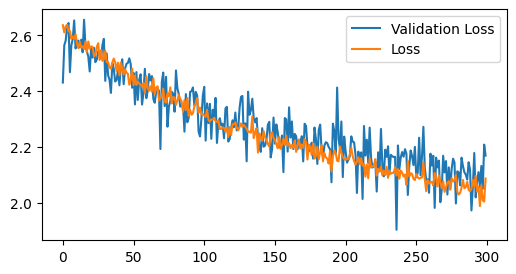

In [12]:
model = Transformer(vocab_size=vocab_size, emb_size=256, n_blocks=4, head_size=256, hidden_size=256, n_layers=2).to(device)
torch.compile(model)
print(f"Millions of parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}")

epochs = 400 # Tailored to be time-comparable to the MLP
batch_size = 512
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.03) 

lossi = []
vlossi = []

for epoch in range(epochs):
    model.train()
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    pred = model(inputs[indexes].to(device)) # everything in the forward pass happens in the model class
    loss = F.cross_entropy(pred.view(-1, vocab_size), labels[indexes].to(device).view(-1))

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    with torch.no_grad():
        model.eval()
        indexes = torch.randint(0, len(val_inputs), (batch_size//8,))
        pred = model(val_inputs[indexes].to(device))
        loss = F.cross_entropy(pred.view(-1, vocab_size), val_labels[indexes].to(device).view(-1))
        vlossi.append(loss.item())

    if epoch % (epochs//10) == 0:
        print(f"Epoch {epoch:_>4d} - Loss: {lossi[-1]:.3f} - Val Loss: {vlossi[-1]:.3f}")

plt.figure(figsize=(6, 3))  
plt.plot(vlossi[100:], label='Validation Loss')
plt.plot(lossi[100:], label='Loss')
plt.legend()

In [13]:
class FullyConnected(nn.Module):  
    def __init__(self, in_size, out_size, hidden_size, n_layers):
        super(FullyConnected, self).__init__()

        self.fc1 = nn.Linear(in_size, hidden_size)
        self.fcx = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(n_layers)])
        self.fc2 = nn.Linear(hidden_size, out_size)
    
    def forward(self, x):
        x = F.gelu(self.fc1(x))
        for fc in self.fcx:
            x = F.gelu(fc(x))
        x = self.fc2(x)
        return x
    
class Attention(nn.Module):
    def __init__(self, emb_size: int):
        super().__init__()
        self.emb_size = emb_size
        self.queries = nn.Linear(emb_size, emb_size)
        self.keys    = nn.Linear(emb_size, emb_size)
        self.values  = nn.Linear(emb_size, emb_size)

    def forward(self, x):
        B, L, _ = x.shape

        q = self.queries(x)
        k = self.keys(x)
        v = self.values(x)

        scores = (q @ k.transpose(-2, -1)) / (x.shape[-1] ** 0.5)
        causal_mask = torch.tril(torch.ones(L, L, device=x.device)).bool()
        scores = scores.masked_fill(~causal_mask, float('-inf'))
        attn = F.softmax(scores, dim=-1)

        out = (attn @ v)
        return out
    
class Block(nn.Module): 
    def __init__(self, emb_size, hidden_size, n_layers):
        super().__init__()

        self.prenorm1 = nn.LayerNorm(emb_size)
        self.att = Attention(emb_size)
        self.prenorm2 = nn.LayerNorm(emb_size)
        self.fc = FullyConnected(emb_size, emb_size, hidden_size, n_layers)

    def forward(self, x):
        x = x + (self.att(self.prenorm1(x)))
        x = x + (self.fc(self.prenorm2(x)))
    
        return x

class Transformer(nn.Module): 
    def __init__(self, vocab_size, emb_size, n_blocks, head_size, hidden_size, n_layers):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.posemb = nn.Embedding(sequence_length, emb_size)
        1
        self.blocks = nn.ModuleList([Block(emb_size, hidden_size, n_layers) for _ in range(n_blocks)])
        self.LinOut = nn.Linear(emb_size, vocab_size)

    def forward(self, x):
        x = (self.embedding(x) + self.posemb(torch.arange(x.size(1)).to(x.device))) 

        for block in self.blocks:
            x = block(x)
            
        x = self.LinOut(x)
        return x


Millions of parameters: 1.98
Epoch ___0 - Loss: 5.940 - Val Loss: 5.713
Epoch __40 - Loss: 3.097 - Val Loss: 3.071
Epoch __80 - Loss: 2.730 - Val Loss: 2.675
Epoch _120 - Loss: 2.533 - Val Loss: 2.425
Epoch _160 - Loss: 2.361 - Val Loss: 2.408
Epoch _200 - Loss: 2.314 - Val Loss: 2.348
Epoch _240 - Loss: 2.223 - Val Loss: 2.081
Epoch _280 - Loss: 2.206 - Val Loss: 2.299
Epoch _320 - Loss: 2.191 - Val Loss: 2.140
Epoch _360 - Loss: 2.082 - Val Loss: 2.103


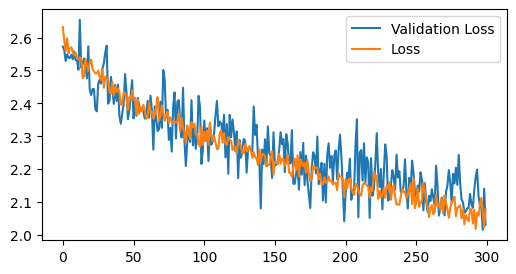

In [14]:
model = Transformer(vocab_size=vocab_size, emb_size=256, n_blocks=4, head_size=256, hidden_size=256, n_layers=2).to(device)
torch.compile(model)
print(f"Millions of parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}")

epochs = 400 # Tailored to be time-comparable to the MLP
batch_size = 512
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.03) 

lossi = []
vlossi = []

for epoch in range(epochs):
    model.train()
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    pred = model(inputs[indexes].to(device)) # everything in the forward pass happens in the model class
    loss = F.cross_entropy(pred.view(-1, vocab_size), labels[indexes].to(device).view(-1))

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    with torch.no_grad():
        model.eval()
        indexes = torch.randint(0, len(val_inputs), (batch_size//8,))
        pred = model(val_inputs[indexes].to(device))
        loss = F.cross_entropy(pred.view(-1, vocab_size), val_labels[indexes].to(device).view(-1))
        vlossi.append(loss.item())

    if epoch % (epochs//10) == 0:
        print(f"Epoch {epoch:_>4d} - Loss: {lossi[-1]:.3f} - Val Loss: {vlossi[-1]:.3f}")

plt.figure(figsize=(6, 3))  
plt.plot(vlossi[100:], label='Validation Loss')
plt.plot(lossi[100:], label='Loss')
plt.legend()